In [226]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

from scipy.stats import linregress

In [227]:
# MODEL 1
def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e10, min = 0)
param5['l_t'].set(value = -1,  max = -1e-7)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

In [228]:
# MODEL 2
def total_resistance(s, sigma, thickness, n, w, l, intercept):
    return s / (sigma * thickness * ( 2* n * (w + l + s) - l - s)) + intercept

gmodel = Model(total_resistance)
param = gmodel.make_params()
param['sigma'].set(value = 1e-6) #, min = 0)
param['intercept'].set(value = 1, min = 0)
param['l'].set(value = 3200e-4, vary = False)
param['w'].set(value = 5e-4, vary = False)
param['n'].set(value = 60, vary = False)
param['thickness'].set(value = 80e-7, vary = False)


    

In [229]:
# VARIABLES

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col_r = ['Spacing (cm)', 'Resistance ($\Omega$)', 'Column']


0.00022105536264915848


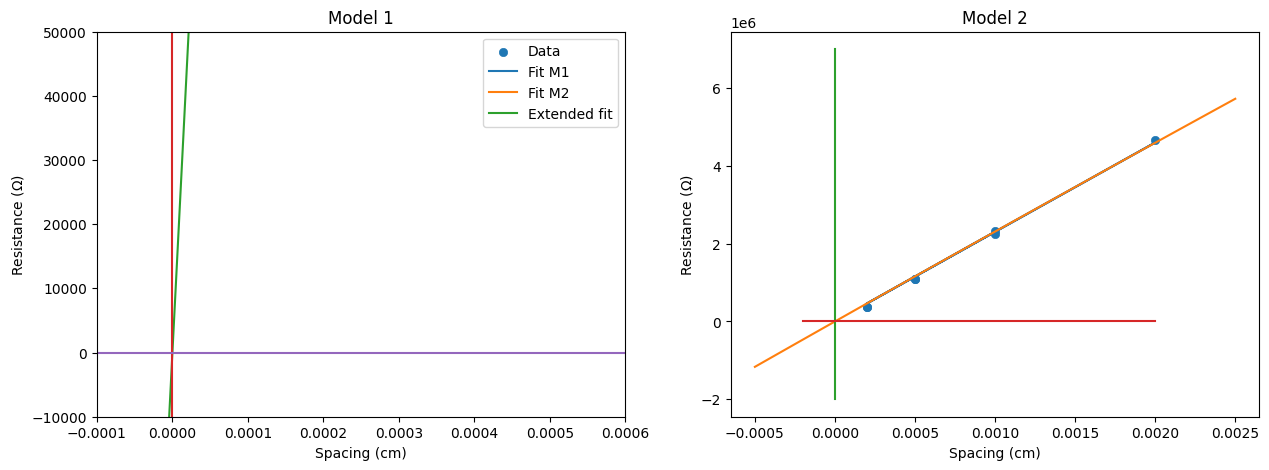

In [230]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_29'

i_v = pd.DataFrame()
r = pd.DataFrame(columns = col_r)
files = [os.path.join(path, i) for i in os.listdir(path)]

# Get resistance from I-V. Get i_v  and r dfs
n = 0
for i in files:
    df = pd.read_csv(i, sep = ';', names = col, skiprows = 1)
    slope, intercept, rvalue, pvalue, stderr = linregress(df[col[0]], df[col[1]])
    df['Fit'] = df[col[0]] * slope + intercept
    if i[-5:-4] == '1':
        df[col_r[0]] = 2e-4
        r.loc[n] = [2e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '2':
        df[col_r[0]] = 5e-4
        r.loc[n] = [5e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '3':
        df[col_r[0]] = 10e-4
        r.loc[n] = [10e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '4':
        df[col_r[0]] = 20e-4
        r.loc[n] = [20e-4, 1/slope, i[-10:-8]]
    df['Column'] = i[-10:-8]
    i_v = pd.concat([i_v, df], ignore_index=True)
    n += 1

spac = [2e-4, 5e-4, 10e-4, 20e-4]
average_df = pd.DataFrame()

for i in spac:
    df = r[r[col_r[0]] == i].mean(numeric_only=True)
    average_df = pd.concat([average_df, df], axis=1)
average_df = average_df.T.reset_index(drop = True)


# FIT
# val_m1 = pd.DataFrame(columns=['rc', 'sigma'])
model1 = gmodel5.fit(r[col_r[1]], param5, s = r[col_r[0]])
model1_av = gmodel5.fit(average_df[col_r[1]], param5, s = average_df[col_r[0]])

# rc = gmodel5.eval(model1.params, s = 0) / 2
# sigma = 1 / (model1.values['r_s'] * 80e-7)
# val_m1.loc[0] = [rc, sigma]

model2 = gmodel.fit(r[col_r[1]], param, s = r[col_r[0]])
model2_av = gmodel.fit(average_df[col_r[1]], param, s = average_df[col_r[0]])

# eval fit from -5um to 25um
x = np.linspace(-5e-4, 25e-4)
y = gmodel5.eval(model1.params, s = x)

# PLOTS

fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.scatterplot(data = r, x = col_r[0], y = col_r[1], edgecolor = None, ax = ax[0], label = 'Data')
ax[0].plot(r[col_r[0]], model1.best_fit, label = 'Fit M1')

sns.scatterplot(data = r, x = col_r[0], y = col_r[1], edgecolor = None, ax = ax[1])

ax[1].plot(r[col_r[0]], model2.best_fit)
ax[0].plot(r[col_r[0]], model2.best_fit, label = 'Fit M2')
ax[0].plot(x, y, label = 'Extended fit')
ax[1].plot(x, y, label = 'Extended fit')

ax[0].plot([0,0],[-2e6, 7e6])
ax[0].plot([-2e-4, 2e-3], [0,0])

ax[1].plot([0,0],[-2e6, 7e6])
ax[1].plot([-2e-4, 2e-3], [0,0])

ax[0].set_title('Model 1')
ax[1].set_title('Model 2')
ax[0].legend()

ax[0].set_xlim(-1e-4, 6e-4)
ax[0].set_ylim(-1e4, 0.5e5)

print(model2.values['intercept'])
# val_m1

# print(model1.fit_report())
# print(model2.fit_report())

# print(model1_av.fit_report())
# print(model2_av.fit_report())

In [231]:
# # Weight by 1/std**2
# spac = [2e-4, 5e-4, 10e-4, 20e-4]
# average_df = pd.DataFrame()
# weights = pd.DataFrame()
# for i in spac:
#     df = r[r[col_r[0]] == i].mean(numeric_only=True)
#     df2 = r[r[col_r[0]] == i].copy()
#     std = np.std(df2[col_r[1]])
#     df['Weight'] = 1 / std ** 2
#     # print(len(df2))
#     # df2['Weight'] = 1 / std ** 2
#     average_df = pd.concat([average_df, df], axis=1)
#     weights = pd.concat([weights, df2], ignore_index=True)
# average_df = average_df.T.reset_index(drop = True)
# r
# # average_df 
# # result = gmodel.fit(average_df[col_r[1]], param, s = r[col_r[0]], fit_kws={"ftol":1e-22, "xtol":1e-22, "gtol":1e-22})
# result = gmodel.fit(average_df[col_r[1]], param, s = r[col_r[0]], fit_kws={"ftol":1e-22, "xtol":1e-22, "gtol":1e-22})
# print(result.fit_report())
# print(result.eval(result.params, s = 0))

# sns.scatterplot(data = average_df, x = col_r[0], y = col_r[1])
# plt.plot(average_df[col_r[0]], result.best_fit)

###################################################################################################################################

# result_all = gmodel5.fit(average_df[col_r[1]], param5, s = average_df[col_r[0]], fit_kws={"ftol":1e-22, "xtol":1e-22, "gtol":1e-22}, weights = average_df['Weight'])
# rc2_all = gmodel5.eval(result_all.params, s = 0)
# rs_all = result_all.values['r_s']
# rs_err = result_all.params['r_s'].stderr
# sigma_all = 1/  (rs_all * thickness * 1e-7)
# # sigma_err = 1/  (rs_err * thickness * 1e-7)
# average_df['Fit'] = result_all.best_fit
# average_df['Sample'] = sample        
# values.loc[0] = [rs_all, rc2_all / 2, sigma_all, sample]

        
# sns.scatterplot(data = i_v, x = col[0], y = col[1], hue = col_r[0])
# sns.lineplot(data = i_v, x = col[0], y = 'Fit', hue = col_r[0])


In [232]:
# [[Model]]
#     Model(total_resistance)
# [[Fit Statistics]]
#     # fitting method   = leastsq
#     # function evals   = 114
#     # data points      = 7
#     # variables        = 2
#     chi-square         = 3.6615e+10
#     reduced chi-square = 7.3230e+09
#     Akaike info crit   = 160.644735
#     Bayesian info crit = 160.536555
#     R-squared          = 0.99735428
# ##  Warning: uncertainties could not be estimated:
# [[Variables]]
#     sigma:      1.4158e-06 (init = 1e-06)
#     thickness:  8e-06 (fixed)
#     n:          60 (fixed)
#     w:          0.0005 (fixed)
#     l:          0.32 (fixed)
#     intercept:  1.0221e-04 (init = 1)